In [14]:
# Needed dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import UECM
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.stats.diagnostic import recursive_olsresiduals
import statsmodels.api as sm
import warnings

plt.style.use('fivethirtyeight')

In [ ]:
# Define the ARDL function
def ardl_model(dataset: pd.DataFrame, y: str, X: list, max_lag: int, exog_orders: list):
    """
    Perform ARDL cointegration analysis and estimate the ECM model.

    Parameters:
    - dataset (DataFrame): The dataset.
    - y (str): The dependent variable.
    - X (list): List of independent variable(s).
    - max_lag (int): Maximum lag order for selection.
    - exog_orders (list): List of manually determined lag orders for exogenous variable(s).

    Returns:
    - The UECM (unconstrained) model
    - Long-run (cointegrating) model summary
    - Short-run (ECM) model summary
    - Plot of the ARDL residuals (ECT)
    - Plot of default error diagnostics
    - The CUSUM plots with 95% confidence bands
    """
    
    data = dataset.copy()
    with warnings.catch_warnings():  # Catch warning to avoid distractions
        warnings.simplefilter("ignore")
        if exog_orders == None:
            def optimum_lags():  # A function to determine optimum lag in case exog_orders is None 
                model_lags = ardl_select_order(
                    endog=data[y],
                    maxlag=max_lag,
                    exog=data[X],
                    maxorder=max_lag,
                    trend="c",
                    ic="aic"
                )
                return model_lags
        
            # Estimate an Unrestricted ECM
            optimum_model = optimum_lags()
            print("The optimum lags selected are: ", optimum_model.model.ardl_order, "\n")
            maxim_order = max(optimum_model.model.ardl_order)
            # Include mechanism for catching exceptions
            try:
                ecm = UECM.from_ardl(optimum_model.model)
                ardl_fitted = optimum_model.model.fit()
            except ValueError as e:
                print(f"Error creating UECM model: {e}")
                print("Auto optimum lag selection failed.")
                print("Try manual order selection for exogenous variables.")
                return
        else:
            # Else estimate UECM with exog_orders
            ecm = UECM(
                endog=data[y],
                lags=3,
                exog=data[X],
                order = {data[X].columns[i]:order for i, order in enumerate(exog_orders)},
                trend="c",
            )
            ardl_fitted = ecm.fit()
            maxim_order = max(exog_orders)  # Extract the maximum lag order
        
        ecm_model = ecm.fit()
        print(f"{ecm_model.summary()}\n")
        ecm_vars_list = list(ecm_model.params.index)  
        ecm_vars = [var for var in ecm_vars_list if "D." in var]  # Extract only differenced variables

        # Print the cointegrating equation
        print(f"{ecm_model.ci_summary()}\n")
        ci_params = ecm_model.ci_params
        ci_params = ci_params.drop(ci_params.index[1])  # Extract the needed long run coefficients

        # Plot the cointegrating errors and default diagnostics
        _ = ecm_model.ci_resids.plot(figsize=(9,4))
        __ = ecm_model.plot_diagnostics(figsize=(15,7))

        # Bounds test
        bounds_test = ecm_model.bounds_test(case=2)
        print(f"{bounds_test}\n")
        print(f"Bounds test critical values\n {bounds_test.crit_vals}")
        bounds_test.crit_vals.to_excel("bounds_crit_vals.xlsx")

        # Estimate error correction form
        ect_vars = [y] + X
        df_ecm = data.copy()
        df_ect = pd.DataFrame({
            var+"_1": data[var].shift(1) for var in ect_vars
        })

        ci_var_list = list(ci_params.index[1:])
        ci_vars = [i.split(".")[0] for i in ci_var_list]  # Extract the variables in the cointegration equation

        df_ect["ECT"] = df_ect.iloc[:,0] - (  # Compute the error correction term
            ci_params.values[0] + sum(
                ci_params.values[i+1]*df_ect[f"{ci_vars[i]}_1"] for i in range(len(ci_vars))
            )
        )

        df_ect.drop(columns=df_ect.columns[1:-1], inplace=True)  # Drop unneeded columns
        df_ect.iloc[:,0] = df_ect.iloc[:,0].diff(1)  # Ensure the DV is differenced
        df_ect.rename(columns={df_ect.columns[0]:f"Δ{y}"}, inplace=True)  # Rename DV appropriately

        # Extract data with appropriate lags for the ECT model
        for var in ect_vars:
            for e_var in ecm_vars:
                if var in e_var:
                    for i in range(maxim_order+1):
                        if str(i) == e_var[-1]:
                            df_ect[f"Δ{var}_{str(i)}"] = df_ecm[var].diff(1).shift(i)
        
        df_ect.dropna(inplace=True)
        
        ecm_ols = sm.OLS(
            df_ect.iloc[:,0], df_ect.iloc[:,1:]
        ).fit()  # Estimate the ECT form

        print("\nError Correction Form")
        print(ecm_ols.summary())

        # CUSUM and CUSUM of squares plots
        ardl_df = pd.DataFrame({
            f"{y}": data[y]
        })

        ardl_vars = list(ardl_fitted.params.index[1:])  # Extract the ARDL variables
        for var in ect_vars:
            for a_var in ardl_vars:
                if var in a_var:
                    for i in range(maxim_order+1):
                        if str(i) == a_var[-1]:
                            ardl_df[f"{var}.L{str(i)}"] = df_ecm[var].shift(i)
        
        ardl_df.dropna(inplace=True)

        try:  # Catch exceptions with plotting CUSUM
            ols_model = sm.OLS(
                ardl_df.iloc[:,0], sm.add_constant(ardl_df.iloc[:,1:])
            ).fit()  # Fit an OLS model from the ARDL model

            recursive_resids = sm.stats.recursive_olsresiduals(ols_model, alpha=0.95)  # Get recursive residuals

            cusum = recursive_resids[5]  # Extract CUSUM statistics

            cusum_bounds = recursive_resids[6]  # Single array containing upper & lower bounds
            cusum_upper = cusum_bounds[0]
            cusum_lower = cusum_bounds[1]
            
            # Plot CUSUM
            plt.figure(figsize=(9, 5))
            plt.plot(cusum, label="CUSUM", color="blue", linewidth=1)
            plt.plot(cusum_upper, 'r--', label="Upper Bound (95%)", linewidth=1)
            plt.plot(cusum_lower, 'r--', label="Lower Bound (95%)", linewidth=1)
            plt.axhline(0, color='black', linestyle='--', linewidth=1)
            plt.title("CUSUM Plot")
            plt.legend()

            plt.tight_layout()
            plt.show()
        except ValueError as e:
            if "singular" in str(e).lower():
                print("\n")
                print("Error plotting CUSUM: The regressor matrix is singular. Possible causes:")
                print("- Too many lags or collinearity among variables")
                print("- Insufficient observations after lagging")
                print("- Missing values leading to excessive data loss")
                print("Consider reducing lags, checking for multicollinearity, or ensuring sufficient observations.")
            else:
                print(f"Unexpected error: {e}")


In [8]:
# Example data (top1% income shares, oil production, globalisation, manufacturing value-added, and inflation)
df = pd.read_excel('term_paper_data.xlsx', index_col=0, parse_dates=True)
df.head()

,top_1,oil,mva,glob,inf
Year,,,,,
1981-01-01,-2.183914,7.272121,3.008832,38.0,0.189072
1982-01-01,-2.183914,7.160069,3.012208,37.0,0.074158
1983-01-01,-2.183914,7.119231,3.049190,38.0,0.208739
1984-01-01,-2.183914,7.235619,2.875617,36.0,0.163992
1985-01-01,-2.183914,7.312487,3.047114,36.0,0.071719


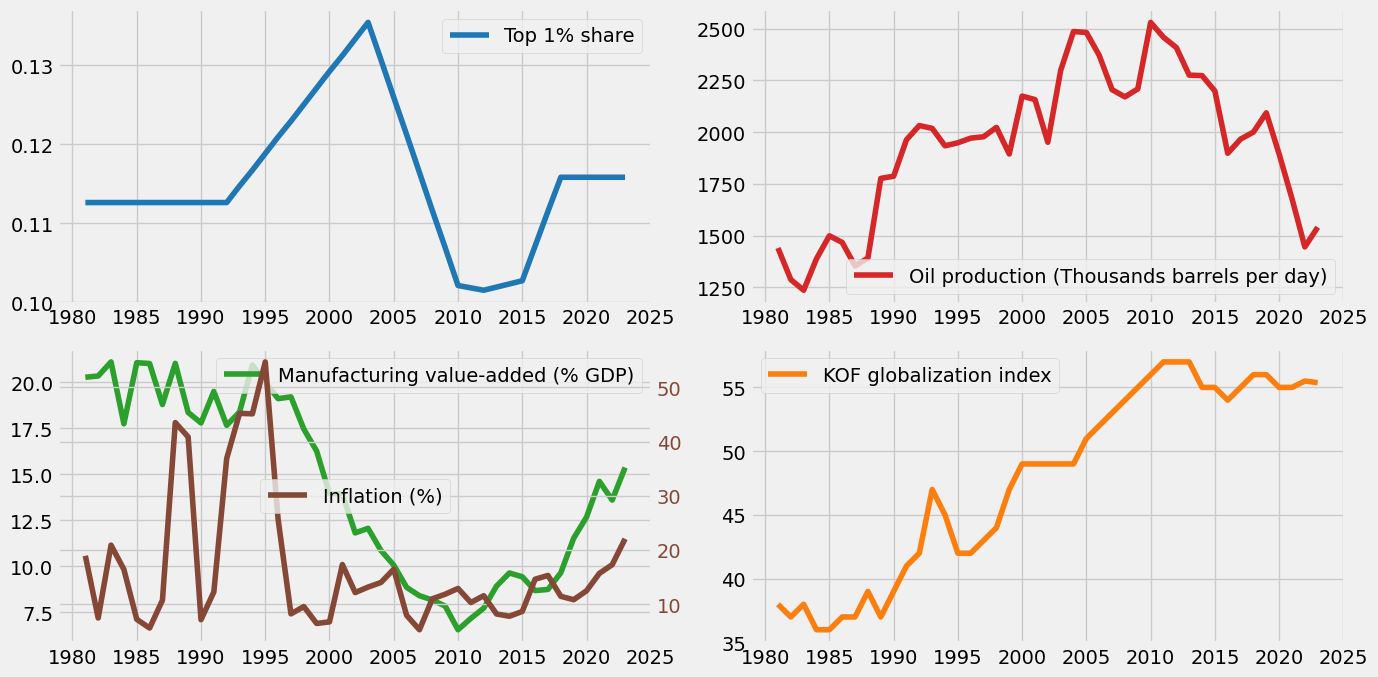

In [9]:
# Plot the data
colors = ["#1f77b4", "#d62728", "#2ca02c", "#ff7f0e"]

fig, axes = plt.subplots(2,2, figsize=(14,3.5*2))

ax = axes.ravel()
labels = ["Top 1% share", "Oil production (Thousands barrels per day)", "Manufacturing value-added (% GDP)", "KOF globalization index"]

for i, col in enumerate(df.columns[:-1]):
    if i < 3:
        plot_col = np.exp(df[col])
    else:
        plot_col = df[col]
    if i == 2:
        ax2 = ax[i].twinx()
        ax2.plot(df.index, 100*df["inf"], label="Inflation (%)", color="#854836")
        ax2.legend(loc="center")
        ax2.tick_params(axis='y', labelcolor="#854836")
    ax[i].plot(df.index, plot_col, label=labels[i], color=colors[i])
    ax[i].legend()

plt.tight_layout()
plt.show()

In [12]:
# Check for unit root
def compute_adf(data):
    """
        This function computes Augmented Dickey-Fuller (ADF) unit
        root tests. It accepts a data frame as input and returns a
        data frame with the ADF statistics and p-values for levels
        and first differences.

        Parameters:
        data (pandas data frame): The data frame with numeric columns.

        Returns:
        Data frame: A summary table with ADF statistics and their 
        p-values.
    """

    adf = pd.DataFrame(index=list(data.columns))

    df1 = data.copy()
    df2 = data.copy().diff().dropna()
    
    for i, df in enumerate([df1, df2]):
        for col in df.columns:
            col_adf = adfuller(df[col], autolag="AIC", regression="ctt", maxlag=9)
            adf.loc[col, f"ADF_{str(i)}"] = round(col_adf[0], 3)
            adf.loc[col, f"P-val_{str(i)}"] = round(col_adf[1], 3)
    
    return adf

compute_adf(df)

,ADF_0,P-val_0,ADF_1,P-val_1
top_1,-4.782,0.002,-3.866,0.046
oil,-4.142,0.021,-6.207,0.000
mva,-1.070,0.984,-7.263,0.000
glob,-2.078,0.785,-5.652,0.000
inf,-5.912,0.000,-2.926,0.332


The optimum lags selected are:  (3, 3, 2, 3, 2) 

                               UECM Model Results                              
Dep. Variable:                 D.top_1   No. Observations:                   43
Model:             UECM(3, 3, 2, 3, 2)   Log Likelihood                 146.101
Method:                Conditional MLE   S.D. of innovations              2.162
Date:                 Sun, 16 Feb 2025   AIC                           -254.202
Time:                         04:59:40   BIC                           -222.114
Sample:                     01-01-1984   HQIC                          -242.600
                          - 01-01-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1807      0.255     -4.636      0.000      -1.709      -0.653
top_1.L1      -0.2686      0.039     -6.839      0.000      -0.350      -

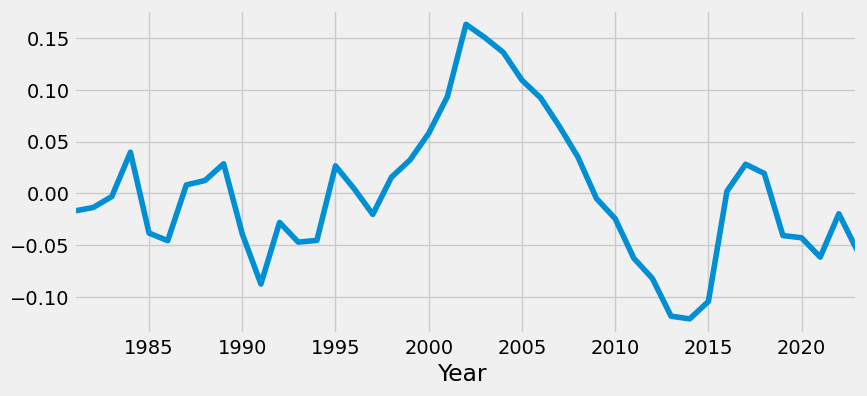

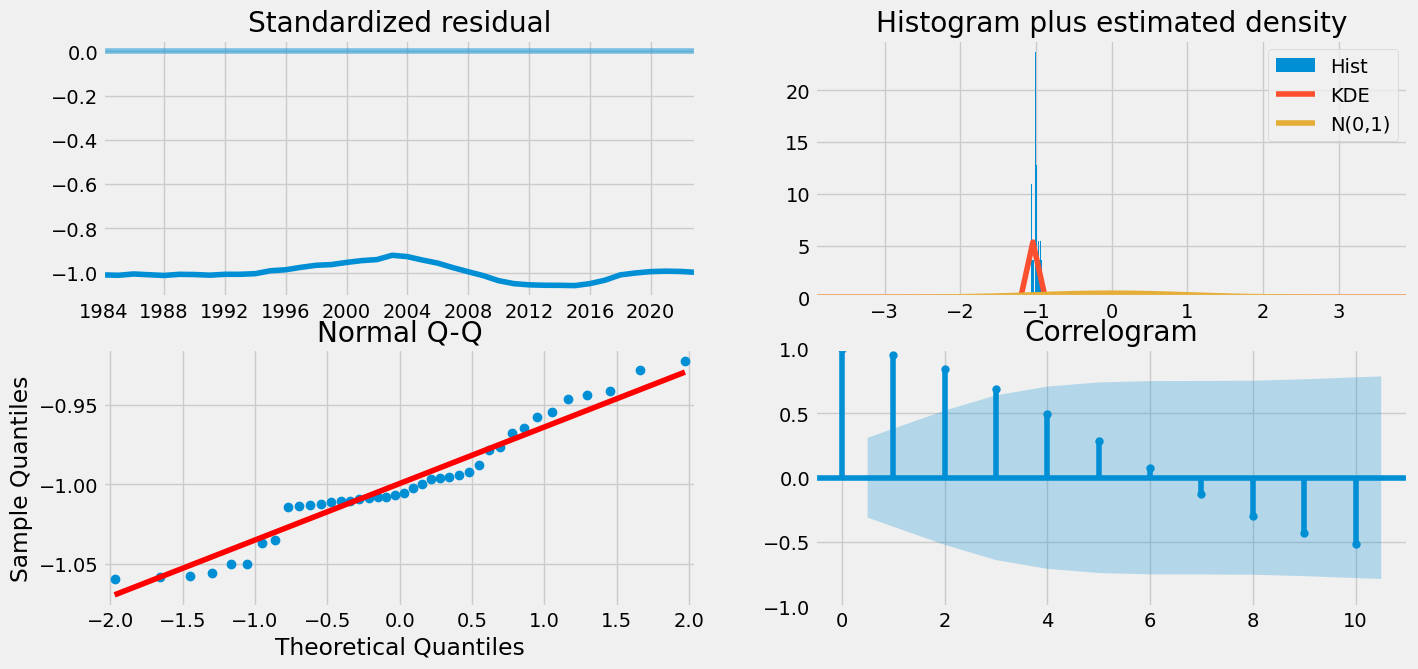

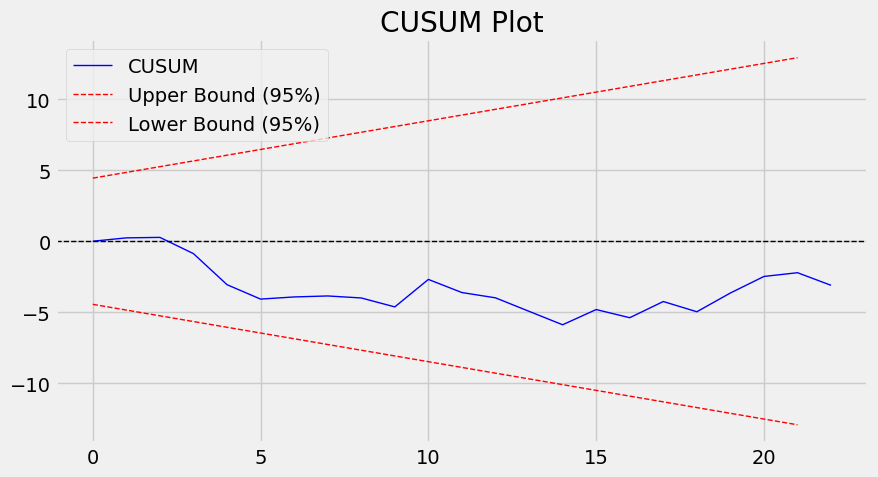

In [16]:
# Apply the ARDL function
ardl_model(df, "top_1", ["oil", "glob", "mva", "inf"], 3, exog_orders=None)